In [1]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.6 MB/s 
     |████████████████████████████████| 376 kB 16.7 MB/s 
     |████████████████████████████████| 58 kB 6.8 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=12d6bfb5b8826fafbac1a22395a1209e69d2fc061310f6b142e1c1fc701f50e3
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=bebb17b95066bbc5d24aefd9ad42244d040badd7da6e1d8ee58e6ce958213d24
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
import os
import time

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim

import segmentation_models_pytorch as smp

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/05_pytorch/set-lipstick-original.zip -d lips_dataset/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: lips_dataset/mask/mask00023595.png  
  inflating: lips_dataset/mask/mask00023596.png  
  inflating: lips_dataset/mask/mask00023597.png  
  inflating: lips_dataset/mask/mask00023598.png  
  inflating: lips_dataset/mask/mask00023599.png  
  inflating: lips_dataset/mask/mask00023600.png  
  inflating: lips_dataset/mask/mask00023601.png  
  inflating: lips_dataset/mask/mask00023602.png  
  inflating: lips_dataset/mask/mask00023603.png  
  inflating: lips_dataset/mask/mask00023604.png  
  inflating: lips_dataset/mask/mask00023605.png  
  inflating: lips_dataset/mask/mask00023606.png  
  inflating: lips_dataset/mask/mask00023607.png  
  inflating: lips_dataset/mask/mask00023608.png  
  inflating: lips_dataset/mask/mask00023609.png  
  inflating: lips_dataset/mask/mask00023610.png  
  inflating: lips_dataset/mask/mask00023611.png  
  inflating: lips_dataset/mask/mask00023612.png  
  inflating: lips_dataset/mask/m

In [5]:
DATASET_FILEPATH = Path('/content/lips_dataset')
IMAGES = '720p'
MASKS = 'mask'
LIST_CSV = 'list.csv'

In [6]:
IMAGES_FILEPATH = DATASET_FILEPATH.joinpath(IMAGES)
MASKS_FILEPATH = DATASET_FILEPATH.joinpath(MASKS)
LIST_CSV_FILEPATH = DATASET_FILEPATH.joinpath(LIST_CSV)

In [7]:
df_lips_images = pd.read_csv(LIST_CSV_FILEPATH)
df_lips_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [8]:
feats = ['filename', 'mask']

df_lips_images = df_lips_images[feats]
df_lips_images.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [9]:
list_of_an_images = sorted([i for i in Path(IMAGES_FILEPATH).iterdir()])
list_of_a_masks = sorted([i for i in Path(MASKS_FILEPATH).iterdir()])

In [10]:
len(list_of_an_images), len(list_of_a_masks)

(28594, 28540)

In [11]:
df_lips_images = df_lips_images.loc[df_lips_images['mask'].isin([i.name for i in list_of_a_masks])]
df_lips_images.reset_index(drop=True, inplace=True)
df_lips_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [12]:
IMG_SIZE = 256

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
model = smp.FPN(encoder_name='resnet50',
                encoder_weights='imagenet',
                classes=1,
                activation='sigmoid'
               ).to(device=device)

preprocess_input = smp.encoders.get_preprocessing_fn('resnet50', pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [15]:
# BACKBONE = 'resnet34'

# segmodel = smp.Unet(encoder_name=BACKBONE, classes=1, activation='sigmoid')
# segmodel.to(device)

# preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

In [16]:
def resize_an_image_and_mask(image_filename, mask_filename, new_size):
    
    image = cv2.imread(str(IMAGES_FILEPATH.joinpath(image_filename)))
    mask = cv2.imread(str(MASKS_FILEPATH.joinpath(mask_filename)))
    
    resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    resized_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    
    return resized_image, resized_mask


class LipsDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, preprocessing=None):
        
        self.data = data
        self.preprocessing = preprocessing
        
        self.images_paths = self.data.iloc[:, 0]
        self.masks_paths = self.data.iloc[:, 1]
        
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        
        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]
        
        img, mask = resize_an_image_and_mask(img_path, mask_path, IMG_SIZE)
        
        img = img.astype(float)
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img)
            img /= 255.0
        
        img = img.permute(2, 0, 1)
      
        cls_mask_1 = mask[..., 1]

        cls_mask_1 = np.where(mask > 50, 1, 0)[:,:,1]
        
        cls_mask_1 = cls_mask_1.astype('float')

        masks = [cls_mask_1]
        
        masks = torch.as_tensor(masks, dtype=torch.float)
        
        
        return img.float(), masks

In [17]:
X_train, X_valid = train_test_split(df_lips_images, test_size=0.3,random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

In [18]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=False)

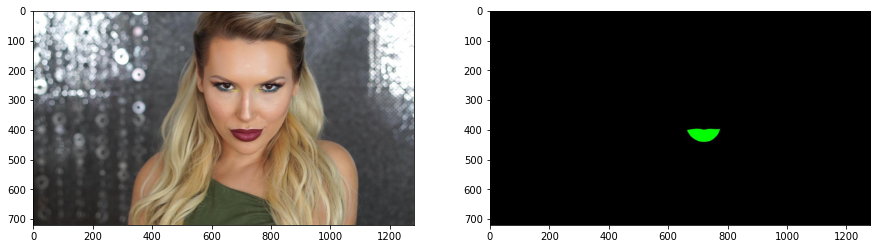

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
img_pic = plt.imread(list_of_an_images[0])
img_mask = plt.imread(list_of_a_masks[0])
ax[0].imshow(img_pic)
ax[1].imshow(img_mask)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(-2.0323) tensor(2.3786)
tensor(0.) tensor(1.)


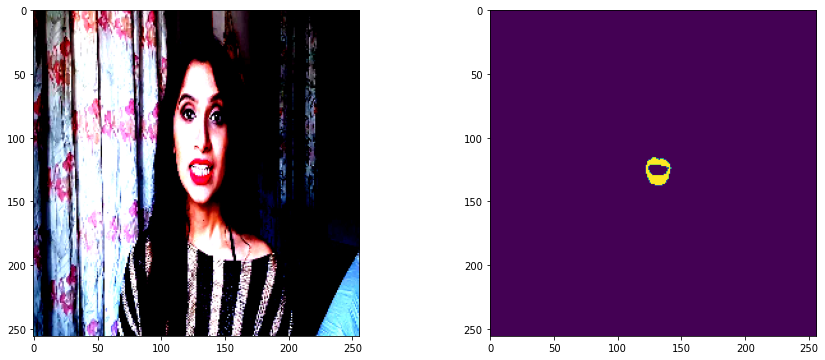

In [20]:
for img, target in train_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[...,0])
    break

In [21]:
criterion = smp.utils.losses.BCELoss()
metrics = [smp.utils.metrics.IoU(), ]
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True
)

In [23]:
# train model

max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 2141/2141 [05:18<00:00,  6.72it/s, bce_loss - 0.001092, iou_score - 0.8945]
Model saved!


In [24]:
net = torch.load('./best_model.pth')

In [25]:
data_iter = iter(train_loader)

In [26]:
images, labels = data_iter.next()
images, labels = images.to(device), labels.to(device)

outputs = model(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


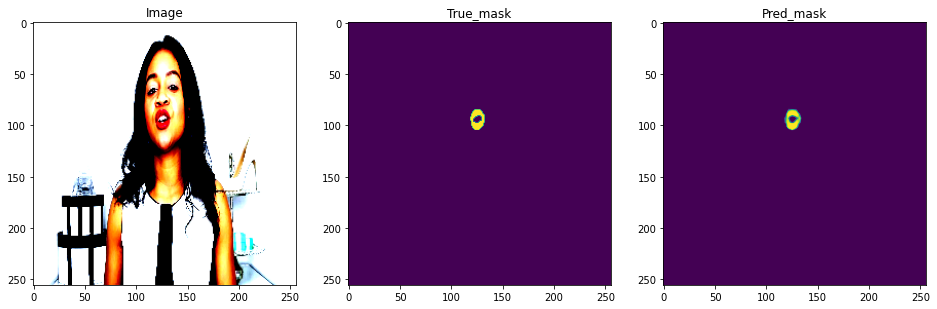

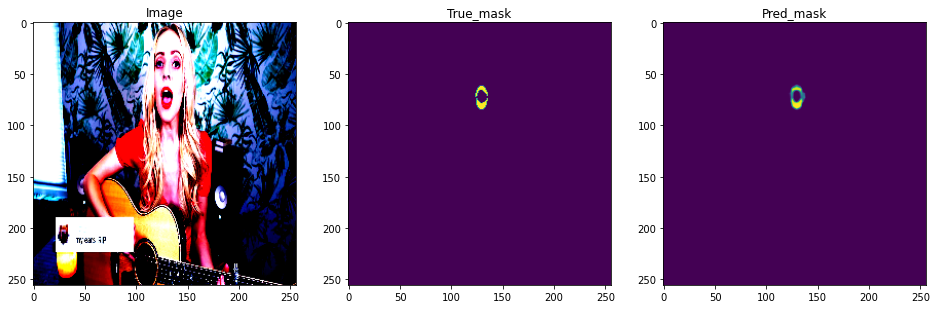

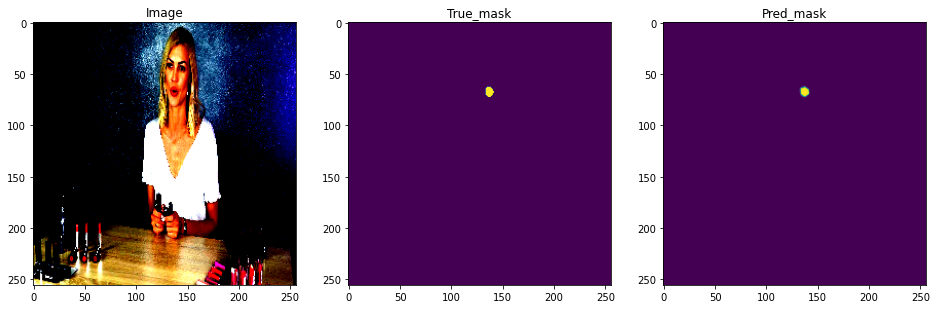

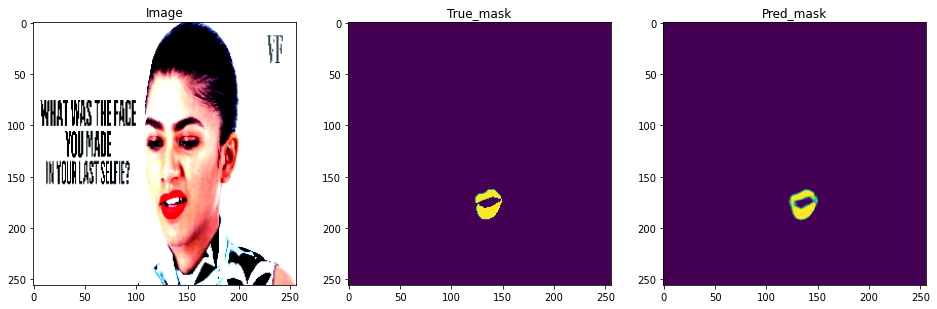

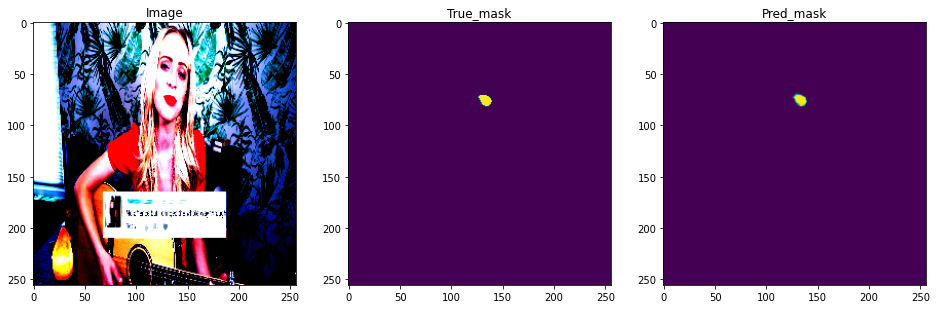

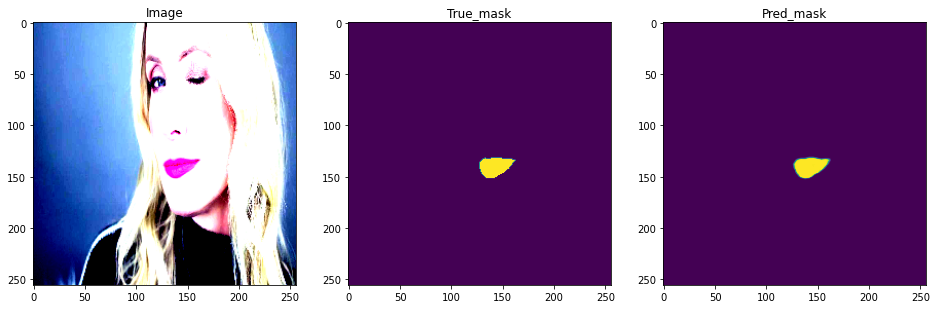

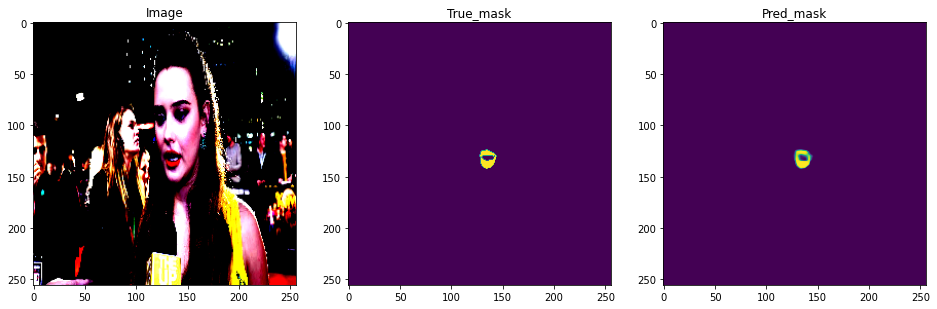

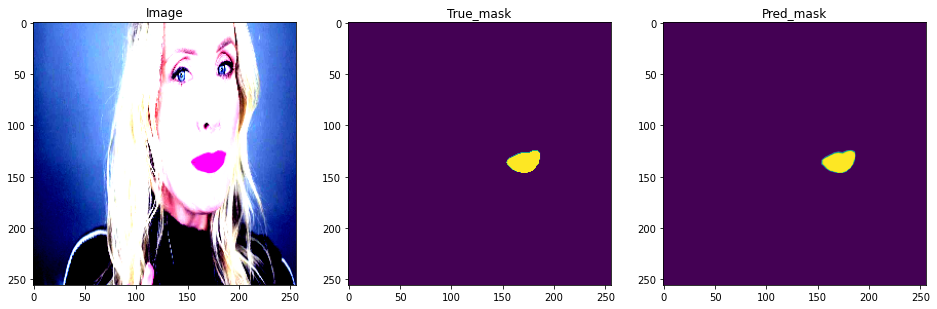

In [29]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0)[...,0])
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0)[...,0])
    ax_3.set_title('Pred_mask')